# Reviewer Guide: Production Noise Characterization

This notebook accompanies the *Production Noise Forecast Ensembles* manuscript and walks a reviewer through the exploratory data analysis that motivated the generalized normal error model in Section 2.2. Run the cells in order and use the notes sprinkled throughout to connect each diagnostic plot to the figures cited in the paper. Key questions answered here:

1. What statistical structure is present in daily production data prior to noise modeling?
2. How do ARIMA residuals behave across analog wells?
3. Why was the generalized normal distribution ultimately selected to represent production noise?

> **Execution tip:** Every block assumes `DAILY_PRODUCTION.csv` is available beside the notebook. If you change the dataset, update the prose in your review to reflect the new analogs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest, norm, laplace, logistic, gennorm

import warnings
warnings.filterwarnings('ignore')

golden_ratio = (1 + np.sqrt(5)) / 2

## 1. Environment & Helper Functions

The next cell imports the packages used throughout the noise audit. If you are reproducing results in a clean environment, install `statsmodels`, `scipy`, and `seaborn` before executing. The helper definitions immediately after this note provide:

- `calc_modified_arps`: deterministic reference decline curve used to benchmark noise statistics (referenced in Section 3.1).
- `calculate_variogram_for_ts`: tool for diagnosing temporal dependence in both absolute rates and relative differences.

> **Reviewer checklist:** Re-run this section whenever you restart the kernel to ensure all downstream cells (ACF/PACF, ARIMA fits, variograms) can access the helper functions.

In [2]:
# create function to calculate modified ARPS decline
def calc_modified_arps(qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = np.arange(0, 365 * 100)
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / 365)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / 365) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / 365) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

def calculate_variogram_for_ts(ts, n_lags=10):
        """
        Calculate the variogram for a time series.

        Parameters:
        - ts: Time series
        - n_lags: Number of lags to calculate the variogram for

        Returns:
        Vector of the semi-variance for each lag
        """
        variances = np.zeros(n_lags)
        for i in range(n_lags):
                variances[i] = 0.5 * np.mean((ts[(i+1):] - ts[:-(i+1)]) ** 2)
        return variances

In [3]:
# load the data into a df
prod = pd.read_csv(r'DAILY_PRODUCTION.csv')
prod['D_DATE'] = pd.to_datetime(prod['D_DATE'])
prod['ON'] = np.where(prod['OIL'] > 1, 1, 0)
prod['DAYS_ON'] = prod.groupby('WELL_NAME')['ON'].cumsum()
prod = prod[prod['ON'] > 0].copy()
prod['PCT_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL'].shift(1) * 100
prod['REL_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL'].shift(1)   
prod['REL_CHANGE_MOVING_AVG'] = prod['REL_CHANGE'].rolling(window=30, center=True).mean()
prod['PCT_CHANGE_MOVING_AVG'] = prod['PCT_CHANGE'].rolling(window=30, center=True).mean()
prod['REL_CHANGE_MOVING_VARANCE'] = prod['REL_CHANGE'].rolling(window=30, center=True).var()

# filter any extreme values that will skew analytic plots further below
prod = prod[prod['PCT_CHANGE'] < 100000].copy()

## 2. Data Ingest & Basic Descriptives

Cells 4–7 load `DAILY_PRODUCTION.csv`, engineer diagnostic columns (percent/relative change, rolling averages, rolling variance), and provide quick sanity checks via `head()`/`describe()`. These outputs map to the descriptive statistics cited in Section 2.1 of the manuscript.

> **Reviewer checklist:**
> - Confirm the CSV path resolves locally.
> - Ensure `prod['ON']` filtering mirrors the manuscript (only producing days retained).
> - If you substitute another dataset, note the change in your review so the statistics remain traceable.

In [4]:
prod.head()

,WELL_NAME,D_DATE,OIL,GAS,GAS_SALES,WATER,ON,DAYS_ON,PCT_CHANGE,REL_CHANGE,REL_CHANGE_MOVING_AVG,PCT_CHANGE_MOVING_AVG,REL_CHANGE_MOVING_VARANCE
2,WELL A,2015-02-13,987.63,660.00,NaN,2511.00,1,2,-32.733291,-0.327333,NaN,NaN,NaN
3,WELL A,2015-02-14,1045.85,608.61,NaN,2161.69,1,3,5.894920,0.058949,NaN,NaN,NaN
4,WELL A,2015-02-15,1011.69,615.61,NaN,1841.76,1,4,-3.266243,-0.032662,NaN,NaN,NaN
5,WELL A,2015-02-16,941.97,568.86,NaN,1608.48,1,5,-6.891439,-0.068914,NaN,NaN,NaN
6,WELL A,2015-02-17,903.01,533.00,NaN,1352.43,1,6,-4.136013,-0.041360,NaN,NaN,NaN


In [5]:
prod.describe().T

,count,mean,min,25%,50%,75%,max,std
D_DATE,7571,2019-11-05 07:17:16.111478016,2015-02-13 00:00:00,2018-01-30 00:00:00,2019-11-11 00:00:00,2021-09-30 12:00:00,2024-01-23 00:00:00,NaN
OIL,7571.0,138.12884,1.03,26.9,52.56,130.43,1610.5,209.683567
GAS,7571.0,195.766805,-8.75,70.5,109.4,223.0,3119.0,223.476981
GAS_SALES,4874.0,297.77698,0.0,84.9225,125.79,474.0,112224.34,1631.020968
WATER,7571.0,206.317637,-129.4,48.04,88.28,206.19,3180.51,305.101966
ON,7571.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
DAYS_ON,7571.0,1330.700964,1.0,632.0,1263.0,1980.0,3100.0,827.014199
PCT_CHANGE,7571.0,17.915952,-99.363636,-12.01377,0.0,12.676011,18978.723404,274.247949
REL_CHANGE,7571.0,0.17916,-0.993636,-0.120138,0.0,0.12676,189.787234,2.742479
REL_CHANGE_MOVING_AVG,7542.0,0.176834,-0.069894,0.015423,0.044702,0.136745,6.974622,0.523638


## 3. Daily Rate Diagnostics (Figures A1–A3)

This block visualizes raw rate vs. time, ACF/PACF, and variograms/lag scatterplots for each analog well. Together they demonstrate the persistence of the dominant decline trend and motivate the need for windowed bootstrapping later in the manuscript.

> **Reviewer checklist:** After running Cells 8–13, verify that:
> - Log-rate plots show the same decline curvature reported in Appendix Figure A1.
> - ACF/PACF highlight autocorrelation through roughly the 4th lag (Section 2.1).
> - Variogram annotations (nugget, sill, end of AR characteristic) match qualitative descriptions in the paper.

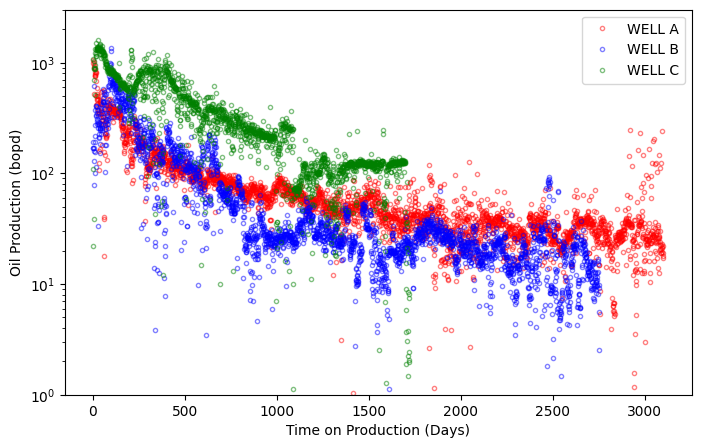

In [6]:
well_names = prod['WELL_NAME'].unique()
labels = ['WELL A', 'WELL B', 'WELL C']
colors = ['r', 'b', 'g']

# plot the rate-time profile for each well
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
for i in range(len(well_names)):
        mask = prod['WELL_NAME'] == well_names[i]
        ax.plot(prod['DAYS_ON'][mask], prod['OIL'][mask], 'o', mfc='none', mec=colors[i], ms=3, alpha=0.5, label=labels[i])
ax.set(yscale='log', ylim=(1,3000), xlabel='Time on Production (Days)', ylabel='Oil Production (bopd)')
ax.legend(labels=['WELL A', 'WELL B', 'WELL C'])
plt.show()

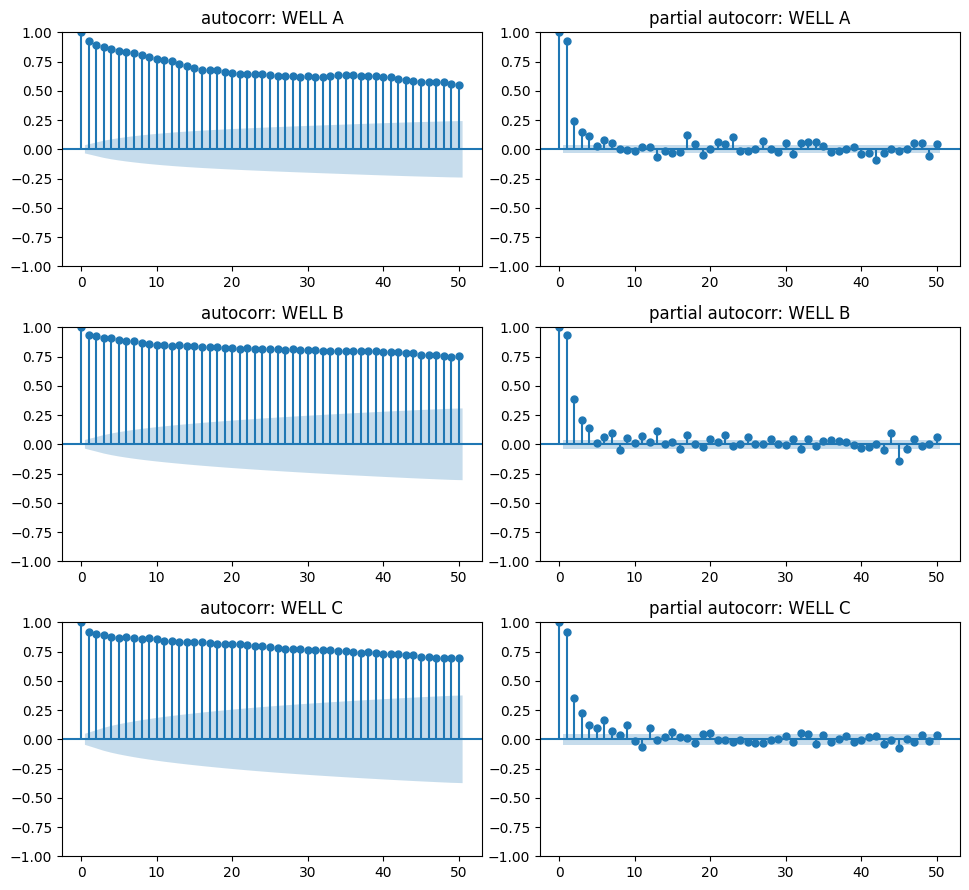

In [7]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    ax = axs[i, 0]
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='autocorr: ' + well)
    ax = axs[i, 1]
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='partial autocorr: ' + well)
plt.tight_layout(); plt.show()

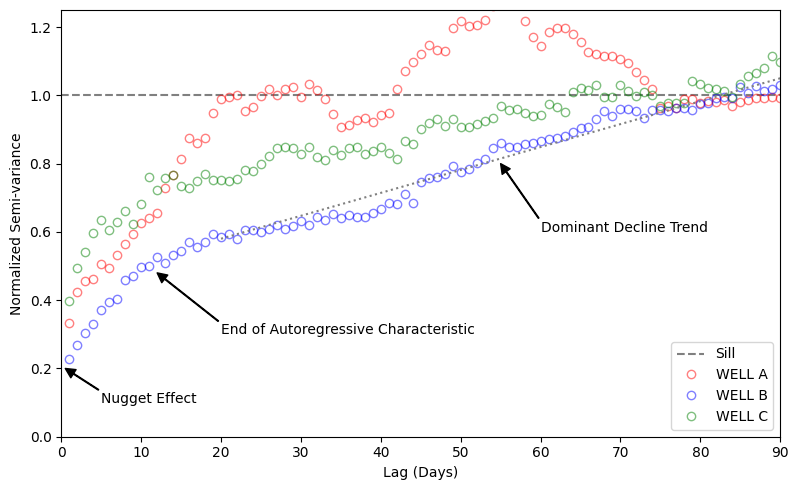

In [8]:
# plot variogram for each well
sills = [1525, 4700, 19000]

lags=90
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
ax.axhline(1, color='gray', linestyle='--', label='Sill')
for i, well in enumerate(prod['WELL_NAME'].unique()):
    well_prod = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna().values
    variances = calculate_variogram_for_ts(well_prod, n_lags=lags)
    ax.plot(range(1, lags + 1), variances / sills[i], 'o', mfc='none', mec=colors[i], alpha=0.5, label=labels[i])
    ax.set(xlabel='Lag (Days)', ylabel='Normalized Semi-variance', ylim=(0, 1.25))
ax.annotate('Nugget Effect', xy=(0.5, 0.2), xytext=(5, 0.1),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=7, headlength=7))
ax.annotate('Dominant Decline Trend', xy=(55, 0.80), xytext=(60, 0.6),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=7, headlength=7))
ax.annotate('End of Autoregressive Characteristic', xy=(12, 0.48), xytext=(20, 0.3),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=7, headlength=7))
ax.plot((20,90), (0.58,1.05), ':', color='gray',)
ax.legend(labels=['Sill'] + labels)
ax.set(xlim=(0, lags), ylim=(0, 1.25))
plt.tight_layout(); plt.show()

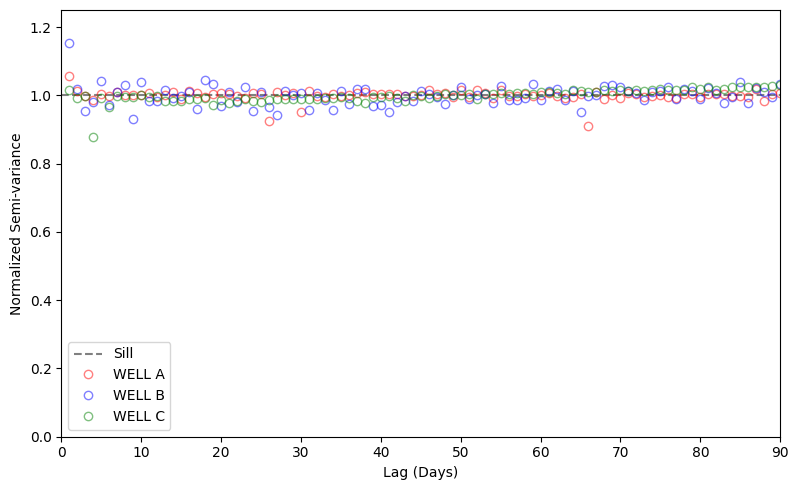

In [9]:
# plot semivariogram of the relative first differences
lags=90
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
ax.axhline(1, color='gray', linestyle='--', label='Sill')
for i, well in enumerate(prod['WELL_NAME'].unique()):
    well_prod = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values
    variances = calculate_variogram_for_ts(well_prod, n_lags=lags)
    ax.plot(range(1, lags + 1), variances / np.mean(variances), 'o', mfc='none', mec=colors[i], alpha=0.5, label=labels[i])
    ax.set(xlabel='Lag (Days)', ylabel='Normalized Semi-variance', ylim=(0, 1.25))
ax.legend(labels=['Sill'] + labels)
ax.set(xlim=(0, lags), ylim=(0, 1.25))
plt.tight_layout(); plt.show()

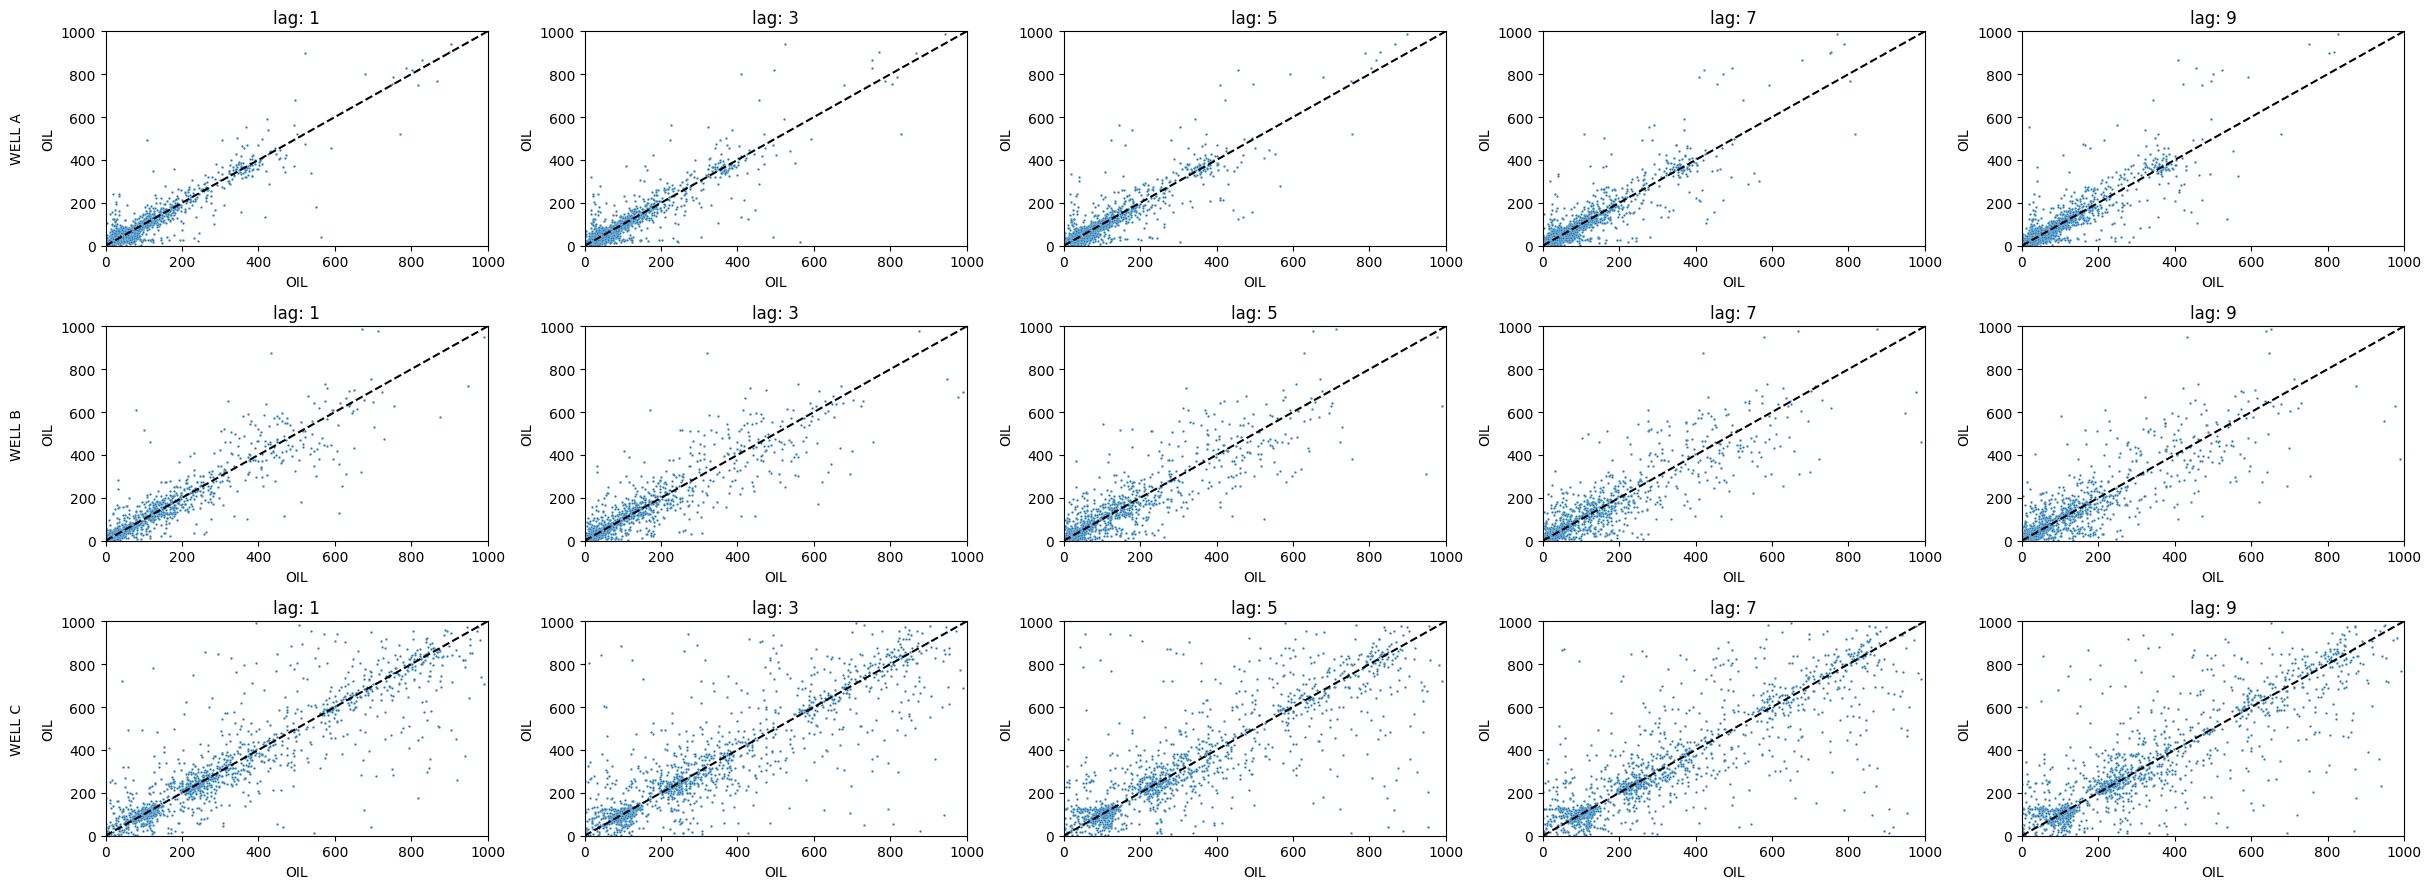

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([0, 1000], [0, 1000], color='black', linestyle='--')
        ax.set(xlim=(0,1000), ylim=(0,1000), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()


### 3.1 ARIMA Modeling of Absolute Rates

Cells 14–18 estimate ARIMA models for each well, inspect residual diagnostics, and summarize skew/kurtosis metrics. These steps link directly to Section 2.2, where we argue that residuals remain heavy-tailed despite detrending.

Key reviewer actions:
- Confirm the ADF tests printed in Cell 14 support an ARIMA(4,0,1) specification.
- Inspect the residual histograms/PACF charts to ensure noise is centered but not Gaussian.
- Note the residual statistics table produced in Cell 15; its values populate Table A1 in the supplement.

ADF Statistic: -6.124337
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3099
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -14700.579
Date:                Tue, 25 Nov 2025   AIC                          29415.157
Time:                        09:29:11   BIC                          29457.429
Sample:                             0   HQIC                         29430.337
                               - 3099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2486      0.225     -1.104      0.270      -0.690       0.193
ar.L1          1.0624      0.016  

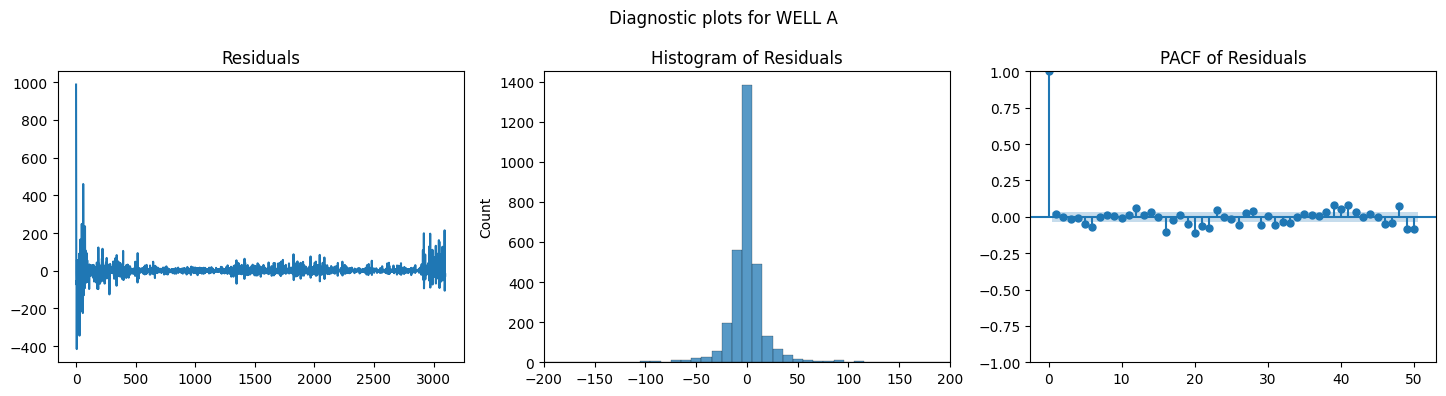

ADF Statistic: -2.294869
p-value: 0.173628
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2752
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -14077.448
Date:                Tue, 25 Nov 2025   AIC                          28168.895
Time:                        09:29:12   BIC                          28210.336
Sample:                             0   HQIC                         28183.867
                               - 2752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0048      0.178      0.027      0.979      -0.344       0.354
ar.L1          1.3736      0.007  

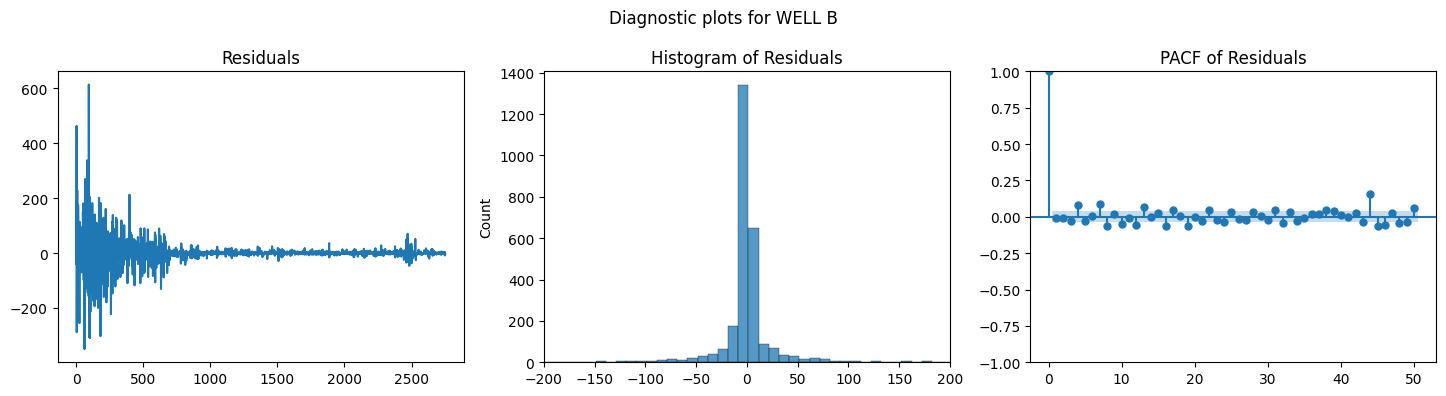

ADF Statistic: -2.472168
p-value: 0.122394
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1720
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -10471.961
Date:                Tue, 25 Nov 2025   AIC                          20957.923
Time:                        09:29:13   BIC                          20996.073
Sample:                             0   HQIC                         20972.038
                               - 1720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2550      0.443     -0.576      0.565      -1.122       0.612
ar.L1          1.3486      0.015  

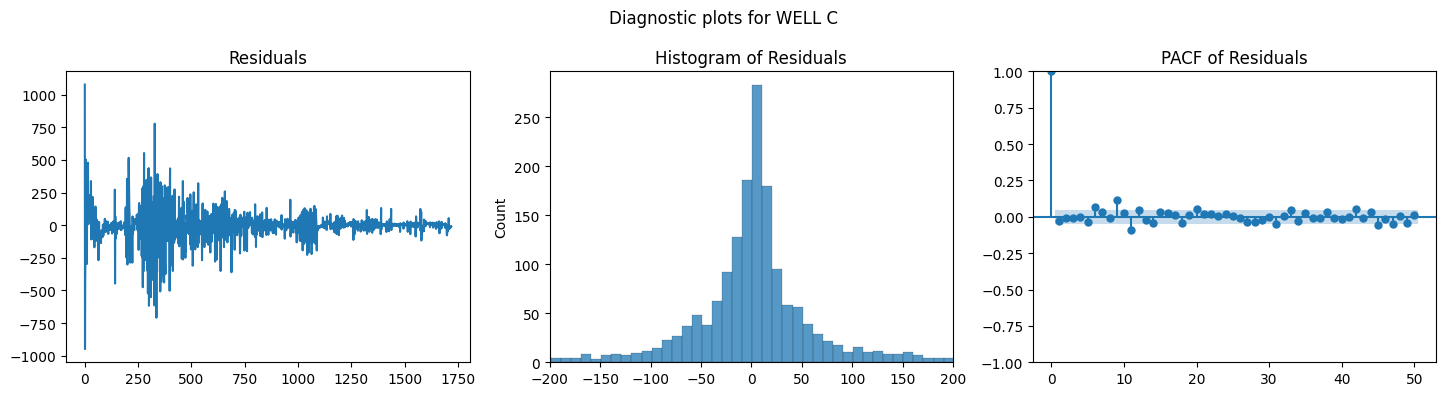

In [11]:

arima_models = {}
for well in prod['WELL_NAME'].unique():
    series = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].values 
    
    # check for stationarirty
    adf_result = adfuller(series)
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    
    # build ARIMA model
    arima_models[well] = ARIMA(series, 
                               order=(4, 0, 1), trend='t').fit()
    print(arima_models[well].summary())
    
    # Plot diagnostic
    fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 4))
    axs[0].plot(arima_models[well].resid)
    axs[0].set_title('Residuals')
    sns.histplot(np.clip(arima_models[well].resid, -1000, 1000), ax=axs[1], binwidth=10)
    axs[1].set(title='Histogram of Residuals', xlim=(-200, 200))
    plot_pacf(arima_models[well].resid, lags=50, ax=axs[2])
    axs[2].set_title('PACF of Residuals')
    fig.suptitle('Diagnostic plots for ' + well)
    plt.tight_layout(), plt.show()

In [12]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    mean = np.mean(arima_models[well].resid)
    median = np.median(arima_models[well].resid)
    std = np.std(arima_models[well].resid)
    skew = robust_skewness(arima_models[well].resid)[1]
    kurt = robust_kurtosis(arima_models[well].resid)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)



,WELL_NAME,MEAN,MEDIAN,STD,SKEW,KURT
0,WELL A,0.245347,0.194703,32.948978,-0.127894,0.538683
1,WELL B,0.318604,-0.442955,40.479675,0.055911,1.307435
2,WELL C,0.879161,3.503558,110.291561,-0.127473,1.046605


- mean and median ~ 0
- Residual STD ranges from 40 - 111
- Skew is ~ 0
- Kurtosis is ~ 1

### 3.2 Residual Distribution Tests

Cells 18–21 compare Laplace vs. generalized normal (GED) fits to the ARIMA residuals and to the deterministic ARPS benchmark. This section underpins the argument that GED with β≈0.5 captures the observed kurtosis while preserving zero-mean behavior.

> **Reviewer checklist:**
> 1. Ensure the Kolmogorov–Smirnov metrics displayed beneath each plot mirror the acceptance/rejection narrative in Section 2.2.
> 2. Confirm the ARPS residual diagnostics (Cell 21) demonstrate the baseline model’s near-Gaussian behavior, highlighting the contrast with field data.

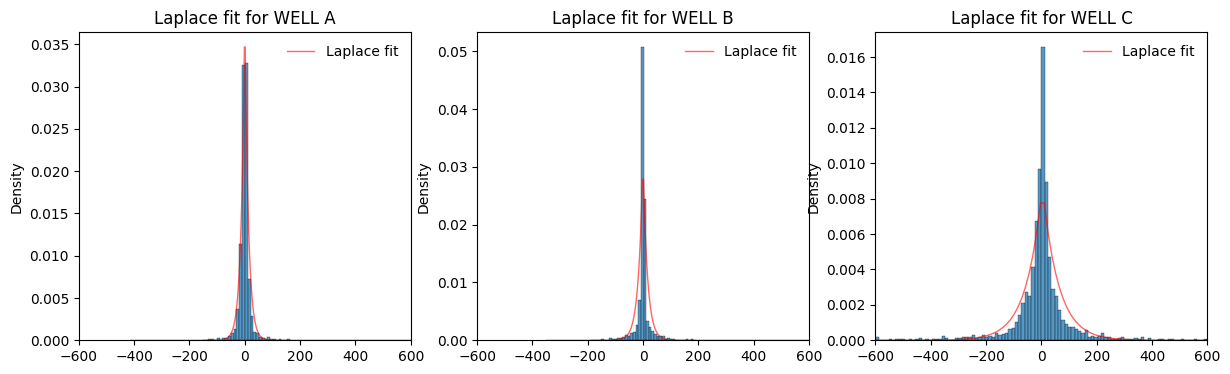

,WELL_NAME,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,WELL A,0.194703,12.806998,-13149.487634,0.086357,1.479088e-20
1,WELL B,-0.442955,15.945456,-12280.307583,0.158226,1.198394e-60
2,WELL C,3.503558,57.247433,-9873.711567,0.099469,2.884330e-15


In [13]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', bins=100)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)


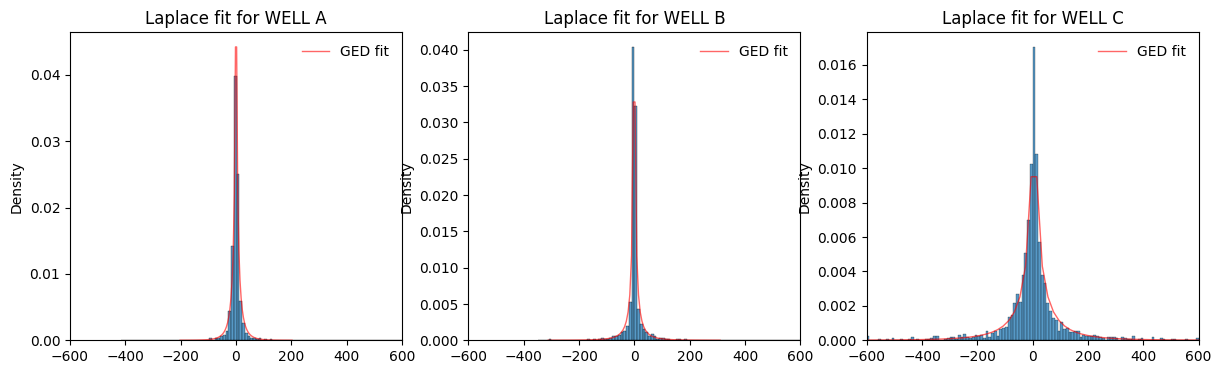

,WELL_NAME,BETA,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,WELL A,0.531534,0.196674,2.619005,-12780.282389,0.031730,0.003814
1,WELL B,0.335513,-0.596823,0.256939,-11226.063006,0.043222,0.000066
2,WELL C,0.469062,4.669083,7.162495,-9653.966707,0.037470,0.015567


In [14]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
gennorm_dist = pd.DataFrame(np.zeros([3,7]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    gennorm_dist.loc[i] = [well, beta, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.01, beta, loc, scale * 3), distribution.ppf(0.99, beta, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
gennorm_dist.head(5)

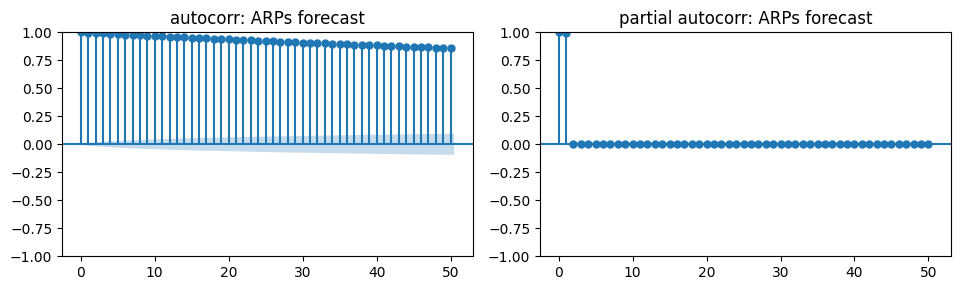

In [15]:
# build the model and view summaries
arps = calc_modified_arps(qi=3000, di=0.7, b=1.001, dmin=0.07, qab=1)

fig, axs = plt.subplots(ncols=2, figsize=(2 * 3 * golden_ratio, 3))
ax = axs[0]
plot_acf(arps, ax=ax, lags=50)
ax.set(title='autocorr: ARPs forecast')
ax = axs[1]
plot_pacf(arps, ax=ax, lags=50)
ax.set(title='partial autocorr: ARPs forecast')
plt.tight_layout(); plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                36500
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -39827.412
Date:                Tue, 25 Nov 2025   AIC                          79662.823
Time:                        09:30:22   BIC                          79696.843
Sample:                             0   HQIC                         79673.638
                              - 36500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        208.9928    3.6e-09   5.81e+10      0.000     208.993     208.993
x1            -0.0820      0.009     -8.703      0.000      -0.101      -0.064
ar.L1          1.0000    1.4e-06   7.13e+05      0.0

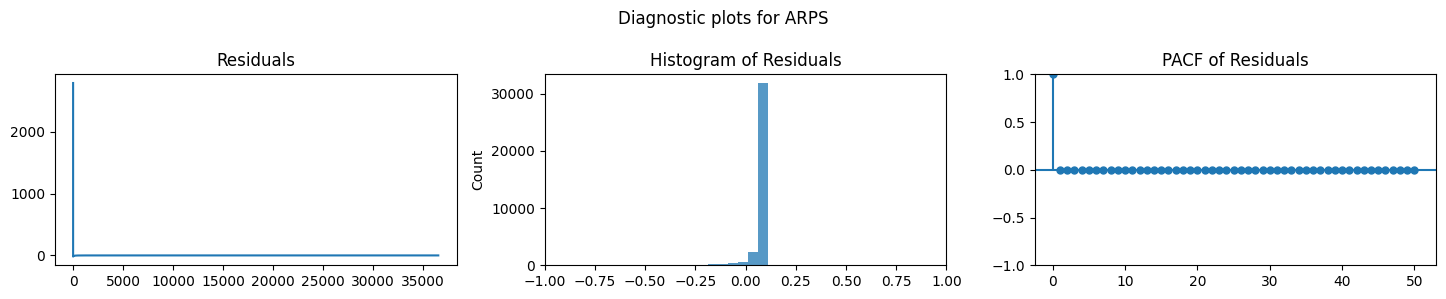

(None, None)

In [16]:
arima_models['ARPS'] = ARIMA(arps, order=(1, 0, 0), trend='ct').fit()  # AR(1) model
print(arima_models['ARPS'].summary())

fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 3))
axs[0].plot(arima_models['ARPS'].resid)
axs[0].set_title('Residuals')
sns.histplot(arima_models['ARPS'].resid, ax=axs[1], binwidth=0.05)
axs[1].set(title='Histogram of Residuals', xlim=(-1,1))
plot_pacf(arima_models['ARPS'].resid, lags=50, ax=axs[2])
axs[2].set_title('PACF of Residuals')
fig.suptitle('Diagnostic plots for ARPS')
plt.tight_layout(), plt.show()

## 4. Relative First-Difference Analysis

Cells 23–34 transition from absolute rates to relative first differences (percent change). These diagnostics show that differencing removes most autocorrelation but preserves leptokurtic behavior, motivating the noise model used for PNFE simulations.

Reviewer focus points:
- Percent-change trajectories (Cell 23) should oscillate around zero with occasional spikes tied to operational events.
- Rolling variance plots (Cells 24–26) demonstrate heteroscedasticity; confirm the narrative matches Section 2.3.
- Stationarity and distribution tests (Cells 27–31) feed into the discussion of noise being IID but heavy-tailed.

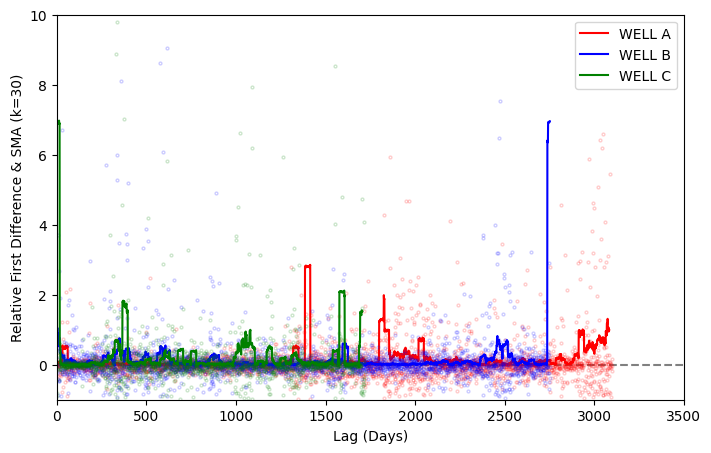

In [17]:
# plot the relative change profile for each well 
arps_pct_change = np.diff(arps) / arps[1:]
arps_pct_change = np.where((arps_pct_change == np.inf) | (arps_pct_change == -np.inf), np.nan, arps_pct_change)
arps_pct_change = arps_pct_change[~np.isnan(arps_pct_change)]

fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
ax.axhline(0, color='gray', linestyle='--')
for i, well in enumerate(prod['WELL_NAME'].unique()):
    well_prod = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna().values
    sma_prod = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE_MOVING_AVG'].dropna().values
    ax.plot(range(len(well_prod)), well_prod, 'o', mfc='none', ms=2, mec=colors[i], alpha=0.2)
    ax.plot(range(len(sma_prod)), sma_prod, '-', color=colors[i], label=f'{labels[i]}')
    ax.set(xlabel='Lag (Days)', ylabel='Relative First Difference & SMA (k=30)', ylim=(0, 1.25))
ax.set(ylim=(-1,10), xlim=(0,3500))
ax.legend(loc='upper right', frameon=True)
plt.show()

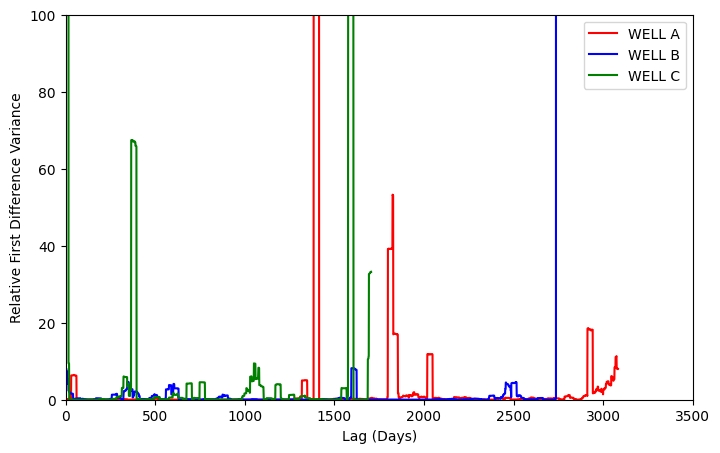

In [18]:
# the relative change variance for each well
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    sma_var = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE_MOVING_VARANCE'].dropna().values
    ax.plot(range(len(sma_var)), sma_var, '-', color=colors[i], label=f'{labels[i]}')
    ax.set(xlabel='Lag (Days)', ylabel='Relative First Difference Variance')
ax.set(ylim=(0,100), xlim=(0,3500))
ax.legend(loc='upper right', frameon=True)
plt.show()

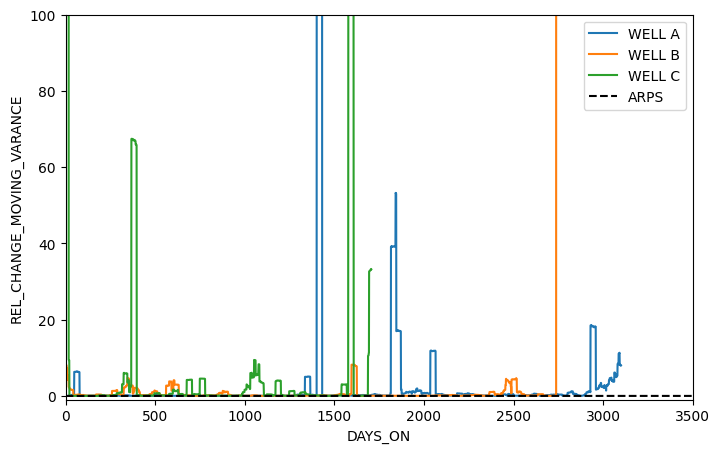

In [19]:
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.lineplot(x='DAYS_ON', y='REL_CHANGE_MOVING_VARANCE', hue='WELL_NAME', data=prod, ax=ax)
ax.plot(range(0, len(arps_pct_change)), arps_pct_change, color='black', linestyle='--', label='ARPS')
ax.set(ylim=(-1,100), xlim=(0,3500))
ax.legend(loc='best', frameon=True)
plt.show()

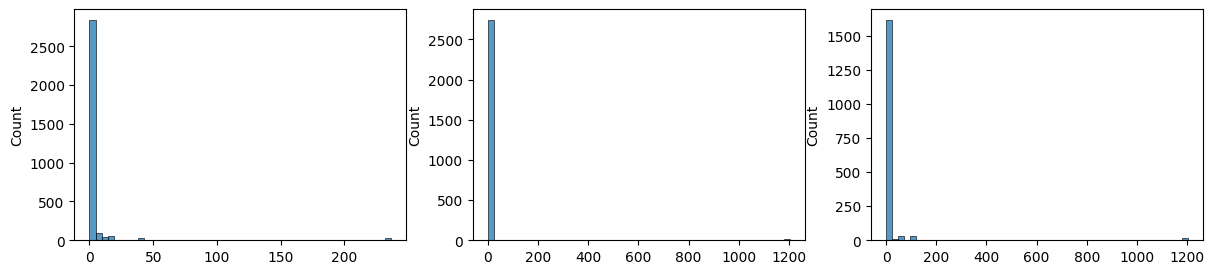

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * 3 * golden_ratio, 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    series = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE_MOVING_VARANCE'].values 
    sns.histplot(series, ax=axs[i], bins=50)

In [21]:
print(f'Variance of Percent Change')
print(f'Well Data: {np.var(prod["PCT_CHANGE"]):.4f}')
print(f'ARPS Forecast: {np.var(arps_pct_change):.4f}')

Variance of Percent Change
Well Data: 75202.0032
ARPS Forecast: 0.0000


In [22]:
# test for stationarity
for well in prod['WELL_NAME'].unique():
    series = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].values 
    
    # check for stationarirty
    print(f'Well: {well}')
    adf_result = adfuller(series)
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

Well: WELL A
ADF Statistic: -58.506313
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Well: WELL B
ADF Statistic: -7.964889
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Well: WELL C
ADF Statistic: -18.611999
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



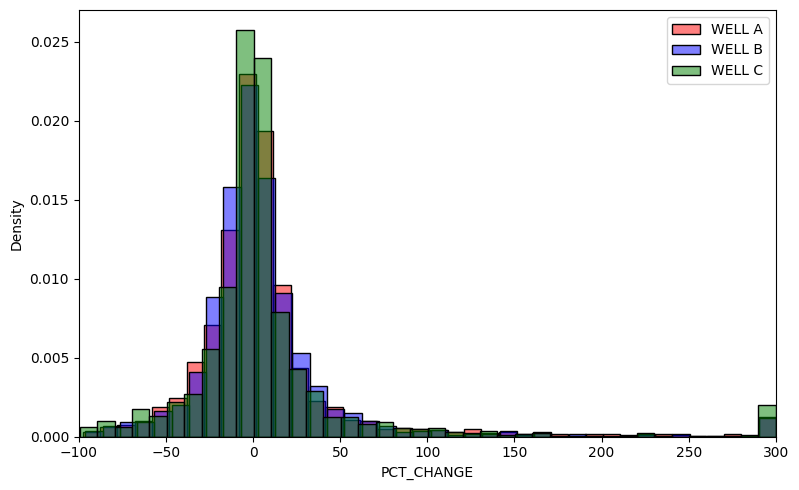

In [23]:
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), -300, 300)
    sns.histplot(data, ax=ax, stat='density', binwidth=10, color=colors[i], label=labels[i], alpha=0.5)
ax.set(xlim=(-100,300))
ax.legend()
plt.tight_layout(); plt.show()

In [24]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), -300, 300)
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    skew = robust_skewness(data)[1]
    kurt = robust_kurtosis(data)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)

,WELL_NAME,MEAN,MEDIAN,STD,SKEW,KURT
0,WELL A,0.156352,0.001220,1.896643,-0.014415,0.644033
1,WELL B,0.104661,-0.002086,0.757902,0.080550,0.430020
2,WELL C,0.339450,0.001166,5.066171,0.029512,1.190674


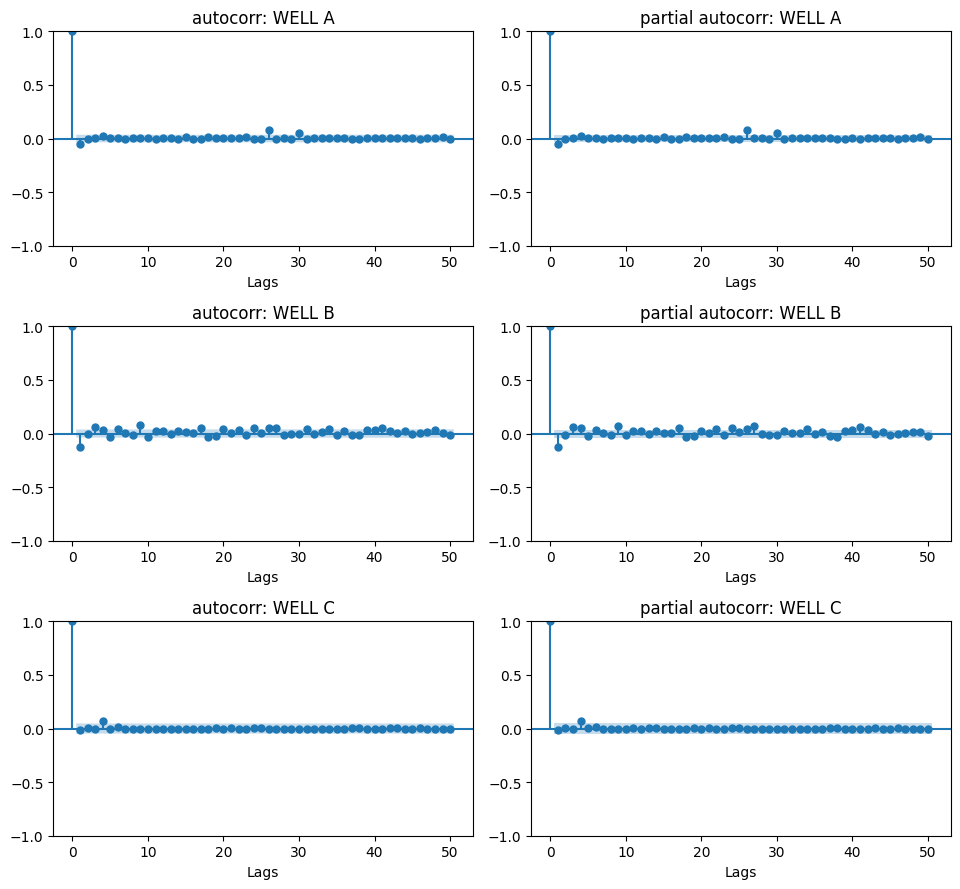

In [25]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), ax=axs[i,0], lags=50)
    axs[i,0].set(title='autocorr: ' + well, xlabel='Lags')
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), ax=axs[i,1], lags=50)
    axs[i,1].set(title='partial autocorr: ' + well, xlabel='Lags')
plt.tight_layout(); plt.show()

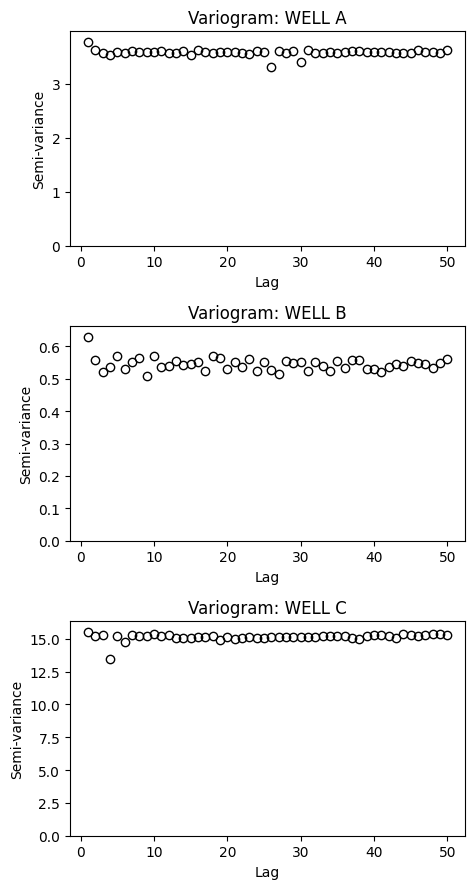

In [26]:
# plot variogram for each well
lags=50
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    variances = calculate_variogram_for_ts(prod.loc[(prod['WELL_NAME'] == well) & 
                                                    (prod['ON'])]['REL_CHANGE'].dropna().values, 
                                           n_lags=lags)
    axs[i].plot(range(1, lags + 1), variances, 'o', mfc='none', mec='k')
    axs[i].set(title='Variogram: ' + well, xlabel='Lag', ylabel='Semi-variance', ylim=(0, np.max(variances)*1.05))
plt.tight_layout(); plt.show()

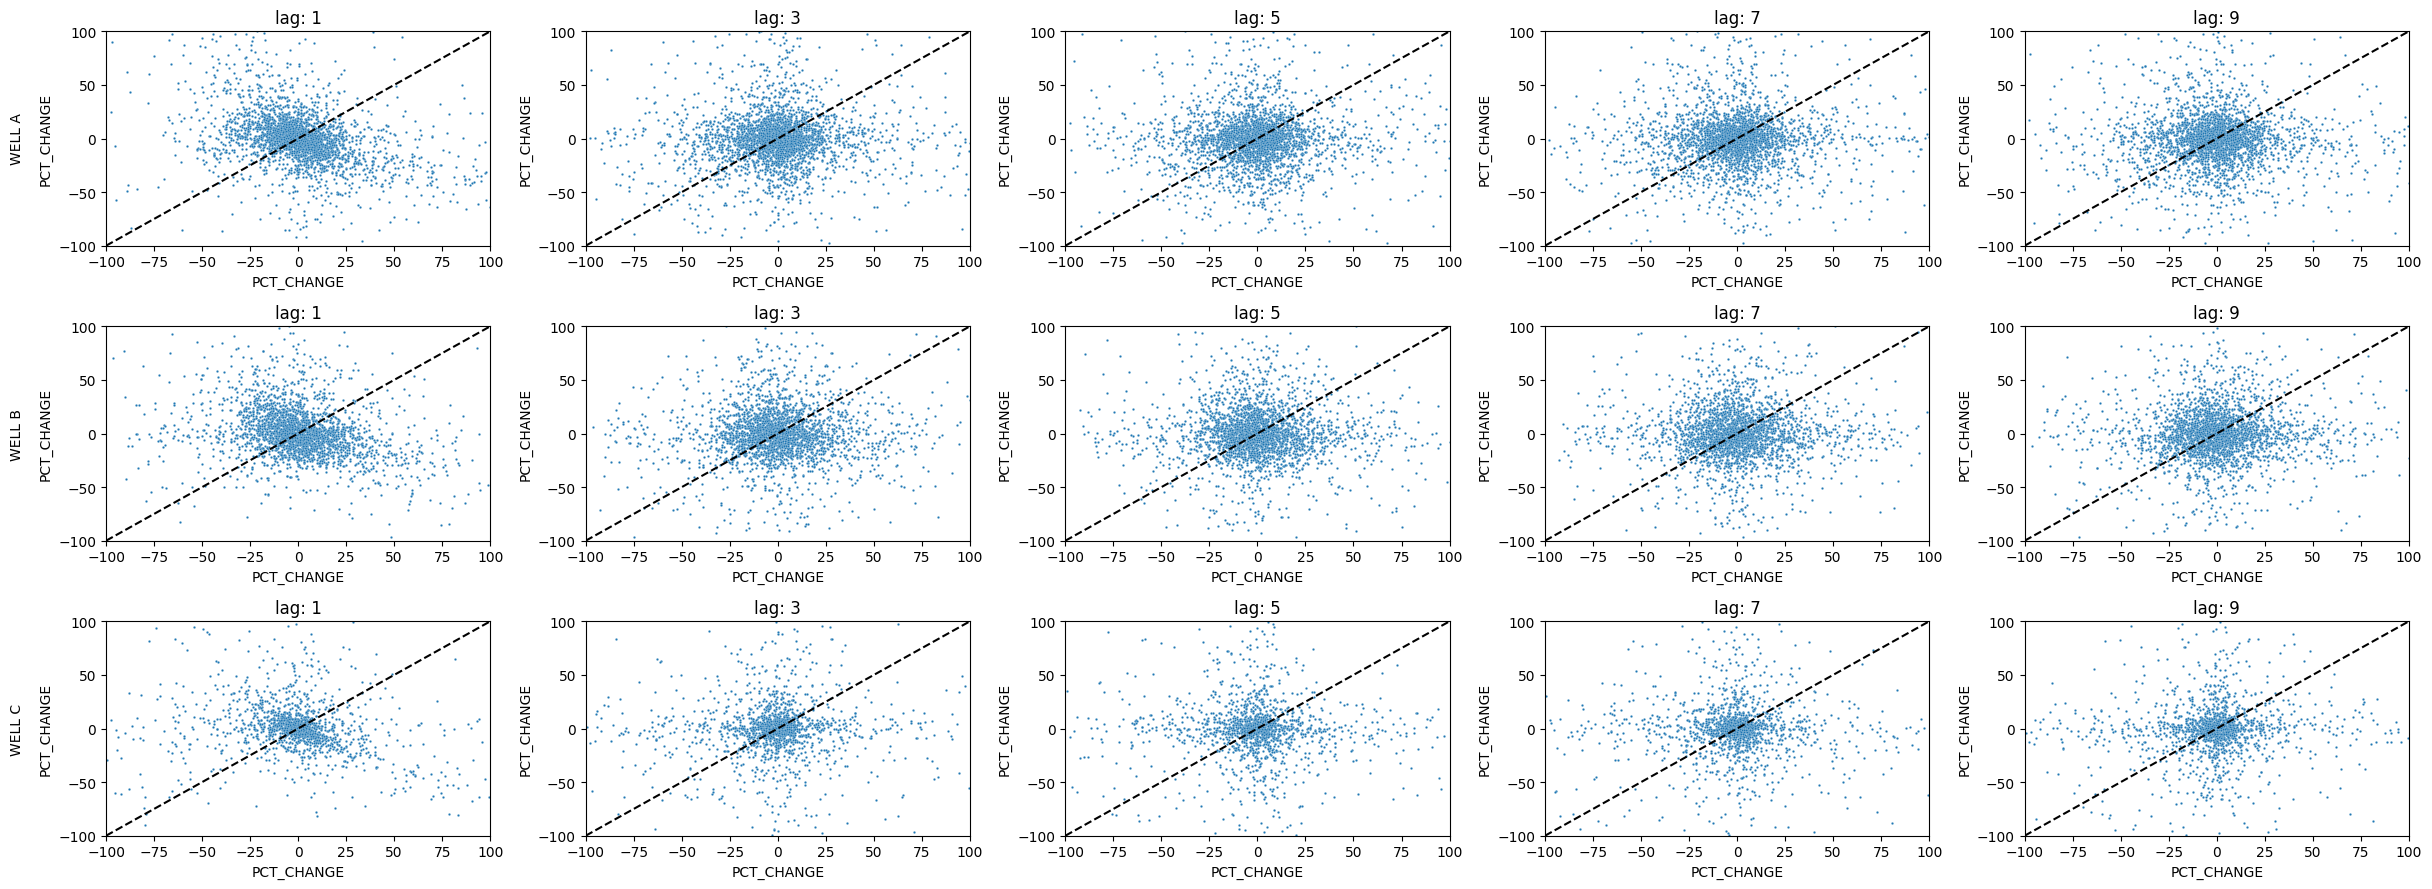

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([-100, 100], [-100, 100], color='black', linestyle='--')
        ax.set(xlim=(-100,100), ylim=(-100,100), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()

### 4.1 Independence Checks

Cells 32–34 revisit scatter/variogram diagnostics using percent-change data. Verify the visuals confirm negligible autocorrelation (lag scatter points hugging the diagonal boundary) so that the remaining modeling challenge is capturing the marginal distribution, not the temporal dependence.

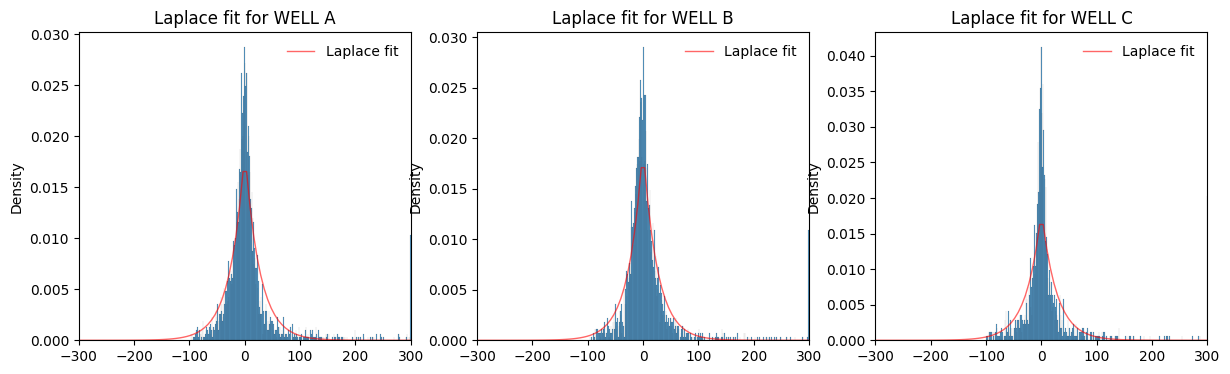

,WELL_NAME,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,WELL A,0.122011,26.861947,-15444.975523,0.069401,2.009125e-13
1,WELL B,-0.208587,25.978877,-13623.586030,0.080216,7.517659e-16
2,WELL C,0.116624,27.280108,-8598.804559,0.103153,2.180586e-16


In [28]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=1)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

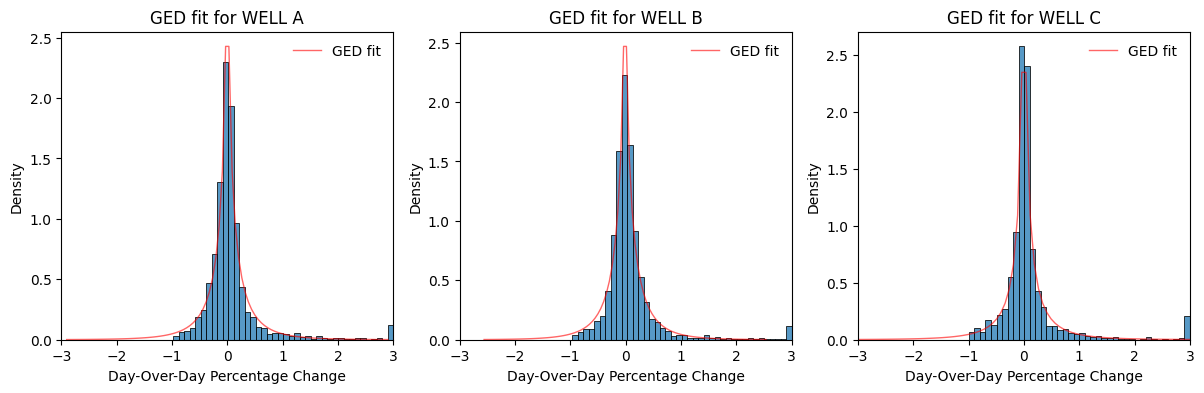

,WELL_NAME,BETA,LOC,SCALE,MEAN,MEDIAN,STD,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,WELL A,0.539005,2.071870e-10,0.059028,0.080256,0.001220,0.462783,-862.927548,0.037786,2.791987e-04
1,WELL B,0.591819,-1.014710e-02,0.078999,0.076354,-0.002086,0.428263,-744.562348,0.054930,1.170949e-07
2,WELL C,0.428669,3.257556e-13,0.021485,0.089695,0.001166,0.527627,-355.383713,0.031675,6.206214e-02


In [29]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,10]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'MEAN', 'MEDIAN', 'STD', 
                                                      'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna().values, -3, 3)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    mean = np.mean(data)
    median = np.median(data)
    std = np.sqrt(distribution.var(beta, loc, scale))
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    laplace_dist.loc[i] = [well, beta, loc, scale, mean, median, std, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=0.1)
    x = np.linspace(distribution.ppf(0.001, beta, loc, scale), distribution.ppf(0.999, beta, loc, scale), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    axs[i].set(title='GED fit for ' + well, xlabel='Day-Over-Day Percentage Change', xlim=(-3,3))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

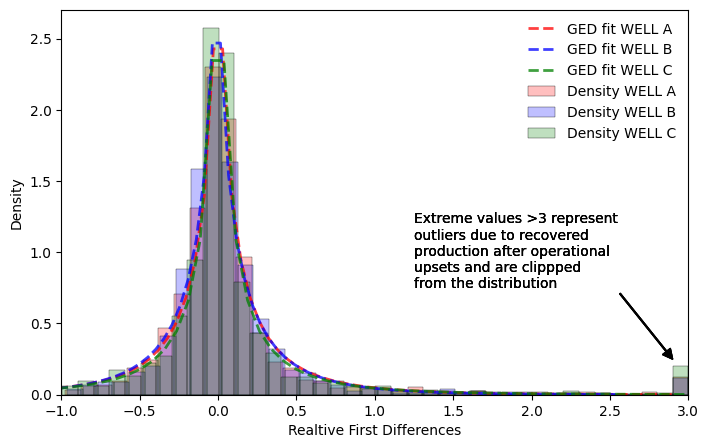

In [30]:
distribution = gennorm

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
laplace_dist = pd.DataFrame(np.zeros([3,10]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'MEAN', 'MEDIAN', 'STD', 
                                                      'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna().values, -3, 3)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    mean = np.mean(data)
    median = np.median(data)
    std = np.sqrt(distribution.var(beta, loc, scale))
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    laplace_dist.loc[i] = [well, beta, loc, scale, mean, median, std, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=ax, stat='density', label=f'Density {labels[i]}', color=colors[i], binwidth=0.1, ec='k', lw=0.25, alpha=0.25)
    x = np.linspace(distribution.ppf(0.001, beta, loc, scale), distribution.ppf(0.999, beta, loc, scale), 100)
    ax.plot(x, distribution.pdf(x, beta, loc, scale), '--', color=colors[i], lw=2, alpha=0.75, label=f'GED fit {labels[i]}')
    ax.set(xlabel='Realtive First Differences', xlim=(-1,3))
    ax.legend(loc='best', frameon=False)
    
    ax.annotate('Extreme values >3 represent\noutliers due to recovered\nproduction after operational\nupsets and are clippped\nfrom the distribution',
                xy=(2.9, 0.25), xytext=(1.25, 0.75), fontweight=200,
                arrowprops=dict(facecolor='black', width=0.5, headwidth=7, headlength=7))
plt.show()

In [31]:
gennorm.rvs(beta=0.5, loc=0, scale=0.05, size=10)

array([-4.86173017e-01,  1.39349419e-01,  7.28083135e-02, -3.14191178e-01,
       -3.29008003e-02,  2.76665022e-02, -1.88206904e-02,  9.14038723e-02,
       -2.68838154e+00,  8.53051296e-04])

## 5. Distribution Decision & Reviewer Checklist

Cells 35–39 finalize the goodness-of-fit comparison and record the chosen GED parameters (`beta=0.5`, `loc=0`, `scale=0.05`). These values flow directly into the PNFE notebook.

Before concluding your review:
1. Confirm Laplace fits underperform relative to GED in both visual overlays and KS statistics.
2. Re-run the final GED fit cell if you alter the dataset; note any parameter shifts in your referee comments.
3. Archive representative plots for the editor if substantial deviations from the manuscript figures occur.